In [1]:
import numpy as np
import pandas as pd
import os
from dask import dataframe as dd
import gc

os.chdir('d:\\学习\\Paper_under_working\\20230302_ML_PAPER\\data')

## Prepare firm charicteriestic data


In [24]:
# load data from open source asset pricing
firm = dd.read_csv('raw_data/signed_predictors_dl_wide.csv', low_memory=False, assume_missing=True)

# choose data from date since 1957
firm_1957 = firm[firm['yyyymm'] > 195612]
firm_1957['yyyymm'] = dd.to_datetime(firm_1957['yyyymm'], format='%Y%m', errors='coerce').dropna()
firm_1957['year_month'] = firm_1957['yyyymm'].dt.to_period('M')

# load monthly price data from CRSP
month_price = pd.read_csv('raw_data/monthly_stock_CRSP_new.csv')

# get date
month_price['date'] = pd.to_datetime(month_price['date'])
month_price['year_month'] = month_price['date'].dt.to_period('M')

# create variables: 'PRC', 'Size', and 'STreversal'
month_price['PRC'] = month_price['PRC'].abs()
month_price['Size'] = month_price['SHROUT'] * month_price['PRC']

# replace missing return with nan
month_price['RETX'] = month_price['RETX'].replace({'C': np.nan, 'B': np.nan})
month_price['STreversal'] = month_price['RETX'].astype(float)

# select variables 
month_price = month_price[['PERMNO', 'year_month', 'PRC', 'STreversal', 'Size']]

# drop nas
month_price.dropna(inplace=True)

# merge with firm data
merge_data = dd.merge(firm_1957, month_price, how='left', left_on=['permno', 'year_month'], right_on=['PERMNO', 'year_month'])

# choose cols
cols = ['permno', 'year_month', 'InvestPPEInv', 'ShareIss1Y', 'ShareRepurchase', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'DelFINL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE', 'DelLTI']

# subset 
merge_data_sub = merge_data[cols].copy()
drop_na = merge_data_sub.dropna().copy()

# convert to pandas dataframe
firm_data = drop_na.compute()

# collect memory
del[firm, firm_1957, month_price, merge_data, merge_data_sub, drop_na]
gc.collect()

# number of observations
assert firm_data.shape == (1396241, 51)

# number of companies in total
firm_data.permno.nunique() == 11830

True

## add CFNAI data

In [25]:
# merge with cfnai
cfnai = pd.read_excel('raw_data/cfnai-data-series-xlsx.xlsx')
cfnai['year_month'] = pd.PeriodIndex(cfnai['Date'], freq='M')
df = pd.merge(firm_data, cfnai, how='left', on='year_month')

df.dropna(inplace=True)

## add semtiment data

In [26]:
sent = pd.read_excel('raw_data/Investor_Sentiment_Data_20220821_POST.xlsx', sheet_name='DATA')
sent['year_month'] = pd.PeriodIndex(sent['yearmo'], freq='M')
sent = sent[['year_month', 'SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's']]
sent = sent.fillna(sent.median())

# add sentiment data
df = pd.merge(df, sent, on='year_month', how='left')

## add Fama-French 5 Factors Data

In [27]:
ff = pd.read_csv('raw_data/F-F_Research_Data_5_Factors_2x3.csv')
ff['year_month'] = pd.PeriodIndex(ff.date, freq='M')
df = pd.merge(df, ff, how='left', on='year_month')

# collect some memory
del[firm_data, cfnai, sent, ff]
gc.collect()

1163

## Prepare abnormal stock return and excess stock return 

In [29]:
# import stock monthly data and fama-french 5 factors data
stock = pd.read_csv('raw_data/monthly_stock_CRSP_new.csv')
ff = pd.read_csv('raw_data/F-F_Research_Data_5_Factors_2x3.csv')

stock['RETX'] = stock['RETX'].replace({'C': np.nan, 'B': np.nan})
stock['RETX'] = stock['RETX'].astype(float)

stock['date'] = pd.to_datetime(stock.date)
stock['year_month'] = stock['date'].dt.to_period('M')
ff['year_month'] = pd.PeriodIndex(ff.date, freq='M')

# merge two datasets
merged = pd.merge(stock, ff, how='left', on='year_month')
# stock excess return
merged['ex_return'] = merged['RETX']*100 - merged['RF']

# sellect variables
data = merged[['PERMNO', 'year_month', 'ex_return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
data = data.dropna()

# clear memory
del[stock, ff, merged]
gc.collect()

# require a stock at least have 36 month return data
data['number'] = data.groupby('PERMNO')['PERMNO'].transform("count")
data = data[data['number'] > 35]

data = data.sort_values(['PERMNO', 'year_month'])

In [30]:
# abnormal return with CAPM, ff3, and ff5 models
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# regression on Mkt-Rf for 36-month rolling widow (CAPM model)
data[['capm_a', 'capm_b']] = data.groupby("PERMNO", group_keys=False).apply(lambda x: RollingOLS(endog=x['ex_return'], exog=sm.add_constant(x[['Mkt-RF']]), window=36).fit().params).copy()

# regression on ff 3 factors for 36-month rolling window
data[['ff3_a', 'ff3_b1', 'ff3_b2', 'ff3_b3']] = data.groupby("PERMNO", group_keys=False).apply(lambda x: RollingOLS(endog=x['ex_return'], exog=sm.add_constant(x[['Mkt-RF', 'SMB', 'HML']]), window=36).fit().params).copy()

# regression on ff 5 factors for 36-month rollilng window
data[['ff5_a', 'ff5_b1', 'ff5_b2', 'ff5_b3', 'ff5_b4', 'ff5_b5']] = data.groupby("PERMNO", group_keys=False).apply(lambda x: RollingOLS(endog=x['ex_return'], exog=sm.add_constant(x[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]), window=36).fit().params).copy()

In [31]:
# abnormal return for the 37th month
data[['ex_return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] =  data.groupby('PERMNO')[['ex_return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].shift(-1)
data.dropna(inplace=True)

# abnormal return of CAPM model
data['ab_capm'] = data['ex_return'] - (data['Mkt-RF']*data['capm_b'])

# abnormal return of ff 3 factors model
data['ab_ff3'] = data['ex_return'] - (data['Mkt-RF']*data['ff3_b1'] + data['SMB']*data['ff3_b2'] + data['HML']*data['ff3_b3'])

# abnormal return of ff 5 factors model
data['ab_ff5'] = data['ex_return'] - (data['Mkt-RF']*data['ff5_b1'] + data['SMB']*data['ff5_b2'] + data['HML']*data['ff5_b3'] + data['RMW']*data['ff5_b4'] + data['CMA']*data['ff5_b5'])

data = data[['PERMNO', 'year_month', 'ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']]

# merge with abnormal return data
dataset = pd.merge(data, df, how='inner', left_on=['PERMNO', 'year_month'], right_on=['permno', 'year_month'])

## Save Prepared Dataset

In [32]:
a = dataset['ab_capm'].mean()
print('The monthly mean stock capm abnormal return is %s' % a)
b = dataset['ab_capm'].std()
print('The monthly standard deviation of stock capm abnormal return is %s' % b)
a = dataset['ab_ff3'].mean()
print('The monthly mean stock ff3 abnormal return is %s' % a)
b = dataset['ab_ff3'].std()
print('The monthly standard deviation of stock ff3 abnormal return is %s' % b)
a = dataset['ab_ff5'].mean()
print('The monthly mean stock ff5 abnormal return is %s' % a)
b = dataset['ab_ff5'].std()
print('The monthly standard deviation of stock ff5 abnormal return is %s' % b)
a = dataset['ex_return'].mean()
print('The monthly mean stock excess return is %s' % a)
b = dataset['ex_return'].std()
print('The monthly standard deviation of stock excess return is %s' % b)

The monthly mean stock capm abnormal return is 0.1015399038418755
The monthly standard deviation of stock capm abnormal return is 16.291366796428687
The monthly mean stock ff3 abnormal return is -0.0001005035947190855
The monthly standard deviation of stock ff3 abnormal return is 16.54170487952805
The monthly mean stock ff5 abnormal return is 0.08599306755994374
The monthly standard deviation of stock ff5 abnormal return is 17.26117328027567
The monthly mean stock excess return is 0.8966402161900004
The monthly standard deviation of stock excess return is 16.955298349438625


In [33]:
dataset.to_pickle('dataset.pkl')

## Summary statistics

In [34]:
dataset[['ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']].describe()

,ab_capm,ab_ff3,ab_ff5,ex_return
count,1.397937e+06,1.397937e+06,1.397937e+06,1.397937e+06
mean,1.015399e-01,-1.005036e-04,8.599307e-02,8.966402e-01
std,1.629137e+01,1.654170e+01,1.726117e+01,1.695530e+01
min,-2.305630e+02,-2.747691e+02,-4.294537e+02,-9.847760e+01
25%,-7.001071e+00,-7.179707e+00,-7.391555e+00,-6.721100e+00
50%,-7.368505e-01,-7.572404e-01,-6.698236e-01,-2.113000e-01
75%,5.663393e+00,5.775803e+00,6.229083e+00,6.927000e+00
max,1.891982e+03,1.892810e+03,1.904276e+03,1.899750e+03


## Plot stock returns

<AxesSubplot: >

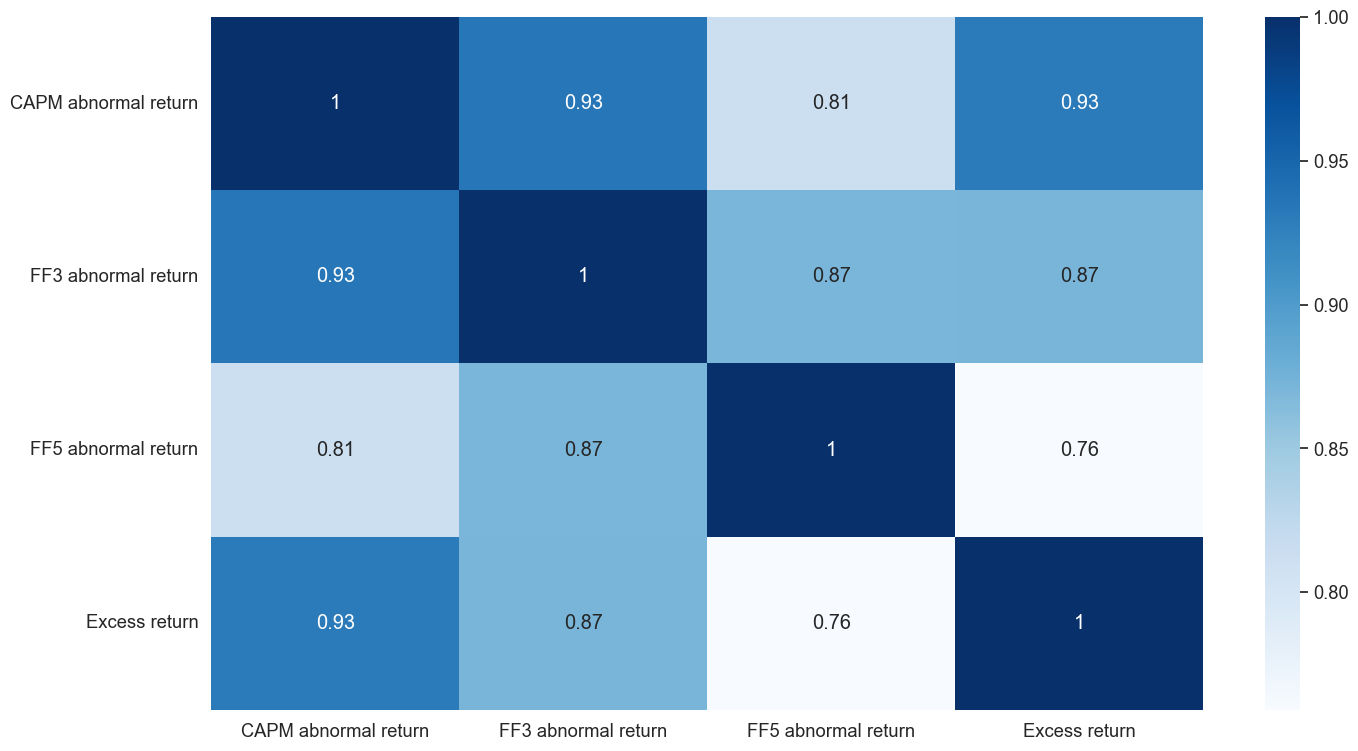

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
sns.set_theme(font_scale=1.2, style='white')
fig, ax = plt.subplots(1,1,figsize=(16,9))

cor = data[['ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']].corr()
cols = ['CAPM abnormal return', 'FF3 abnormal return', 'FF5 abnormal return', 'Excess return']
cor.columns=cols
cor.index=cols

sns.heatmap(cor, cmap="Blues", annot=True)

In [36]:
dat = data.groupby('year_month').agg(capm_mean=pd.NamedAgg(column='ab_capm', aggfunc='mean'),
                                     ff3_mean=pd.NamedAgg(column='ab_ff3', aggfunc='mean'),
                                     ff5_mean=pd.NamedAgg(column='ab_ff5', aggfunc='mean'),
                                     ex_mean=pd.NamedAgg(column='ex_return', aggfunc='mean'),
                                     capm_std=pd.NamedAgg(column='ab_capm', aggfunc='std'),
                                     ff3_std=pd.NamedAgg(column='ab_ff3', aggfunc='std'),
                                     ff5_std=pd.NamedAgg(column='ab_ff5', aggfunc='std'),
                                     ex_std=pd.NamedAgg(column='ex_return', aggfunc='std'))

# convert back to fraction from pecentage 
dat = dat.divide(100)
# convert data type of "year_month" for plot
dat['year_month'] = dat.index.astype(str)
dat['year_month'] = pd.to_datetime(dat['year_month'], format='%Y-%m') 
# create column names
cols = ['CAPM abnormal return', 'FF3 abnormal return', 'FF5 abnormal return', 'Excess return', 'year_month']
# compute cumulative returns
dat[['capm_mean', 'ff3_mean', 'ff5_mean', 'ex_mean']] = dat[['capm_mean', 'ff3_mean', 'ff5_mean', 'ex_mean']].cumsum()

# prepare for plot
tidy1 = dat[['capm_mean', 'ff3_mean', 'ff5_mean', 'ex_mean', 'year_month']]
tidy1.columns = cols
tidy1 = tidy1.melt(id_vars='year_month').rename(columns=str.title)
tidy2 = dat[['capm_std', 'ff3_std', 'ff5_std', 'ex_std', 'year_month']]
tidy2.columns = cols
tidy2 = tidy2.melt(id_vars='year_month').rename(columns=str.title)

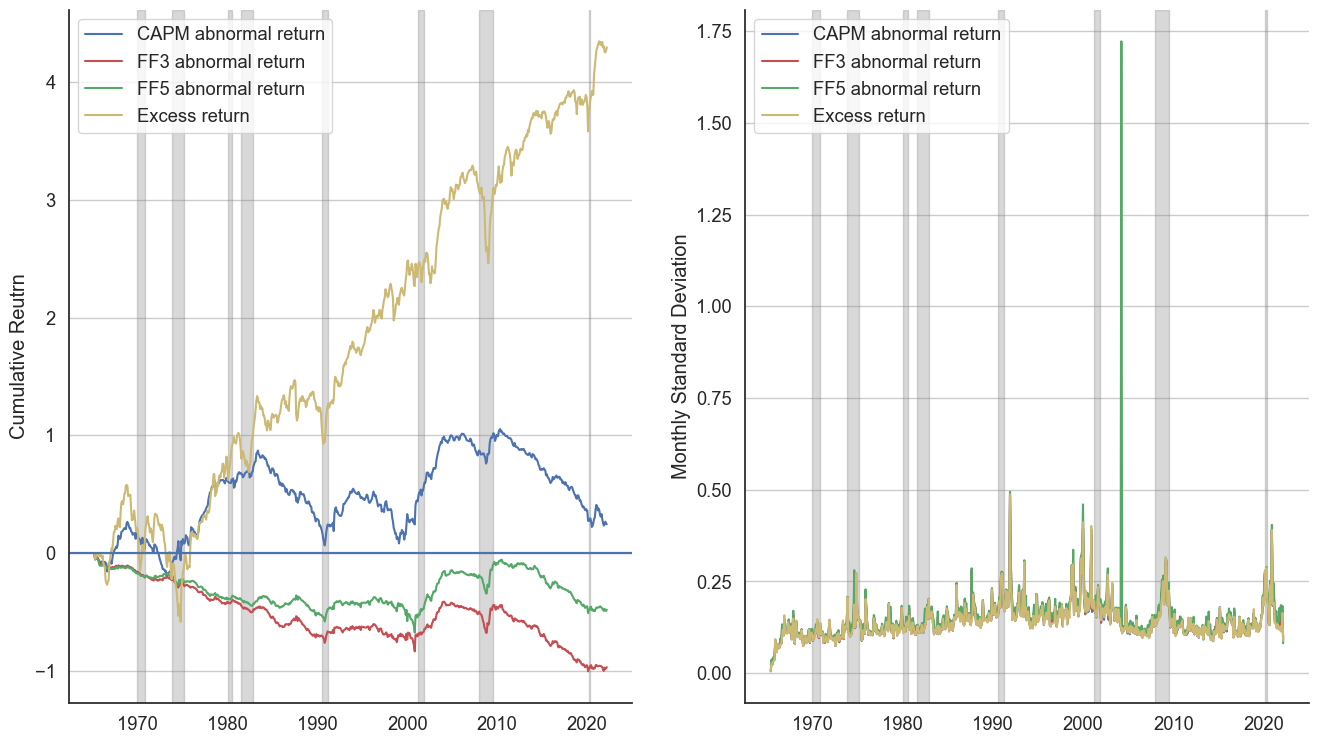

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(1,2,figsize=(16,9))

# load nber recession data
nber = pd.read_excel('raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

colors = ['b', 'r', 'g', 'y']
sns.lineplot(data=tidy1, x='Year_Month', y='Value', hue='Variable', palette=colors, ax=ax[0])
sns.lineplot(data=tidy2, x='Year_Month', y='Value', hue='Variable', palette=colors, ax=ax[1])

# shade recession area
for a in range(0,2):
  for i in range(8):
    ax[a].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')
# hide legend title
  handles, labels = ax[a].get_legend_handles_labels()
  ax[a].legend(handles=handles[0:], labels=labels[0:], loc='upper left')
  ax[0].axhline() 
  ax[a].grid(axis='y')
  
ax[0].set(xlabel='', ylabel='Cumulative Reutrn')
ax[1].set(xlabel='', ylabel='Monthly Standard Deviation')

# remove frame
sns.despine(fig)

## Plot Macro Data

In [2]:
cfnai = pd.read_excel('raw_data/cfnai-data-series-xlsx.xlsx')

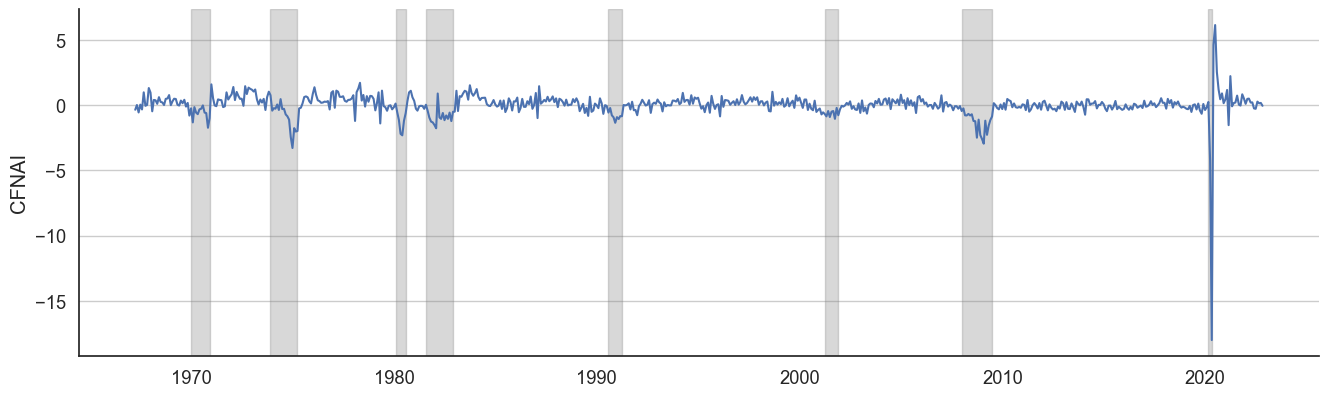

In [4]:
# plot CFNAI index with NBER suggested recessions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

# load nber recession data
nber = pd.read_excel('raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

fig, ax = plt.subplots(1,1,figsize=(16,4.5))
sns.lineplot(data=cfnai, x='Date', y='CFNAI')
plt.xlabel('')
ax.grid(axis='y')
# shade recession area
for i in range(8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

# remove frame
sns.despine(fig)

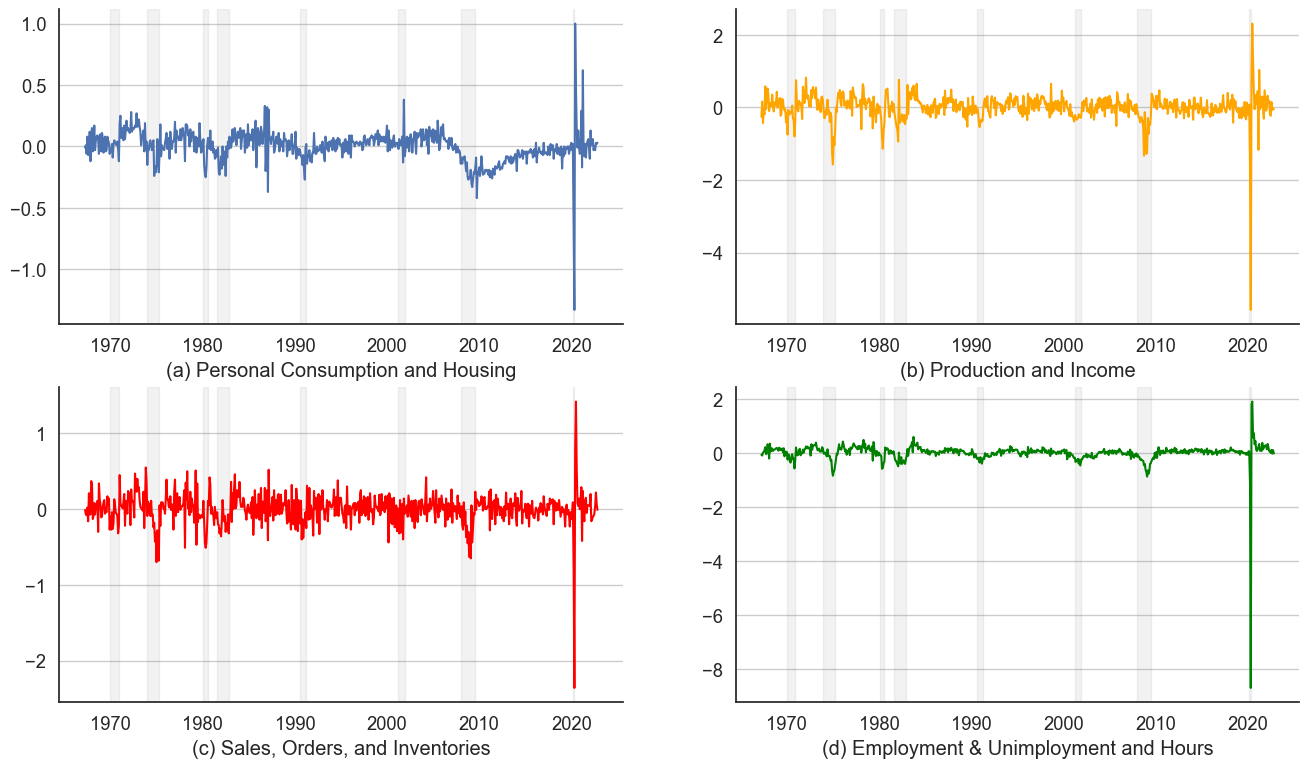

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(2,2, figsize=(16,9))
sns.lineplot(data=cfnai, x='Date', y='C_H', ax=ax[0][0])
sns.lineplot(data=cfnai, x='Date', y='P_I', ax=ax[0][1], color='orange')
sns.lineplot(data=cfnai, x='Date', y='SO_I', ax=ax[1][0], color='red')
sns.lineplot(data=cfnai, x='Date', y='EU_H', ax=ax[1][1], color='green')

ax[0][0].set(xlabel='(a) Personal Consumption and Housing', ylabel=None)
ax[0][1].set(xlabel='(b) Production and Income', ylabel=None)
ax[1][0].set(xlabel='(c) Sales, Orders, and Inventories', ylabel=None)
ax[1][1].set(xlabel='(d) Employment & Unimployment and Hours', ylabel=None)

# shade recession area
for i in range(8):
 ax[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 
for a in range(0,2):
  for b in range(0,2):
    ax[a][b].grid(axis='y')

# remove frame
sns.despine(fig)

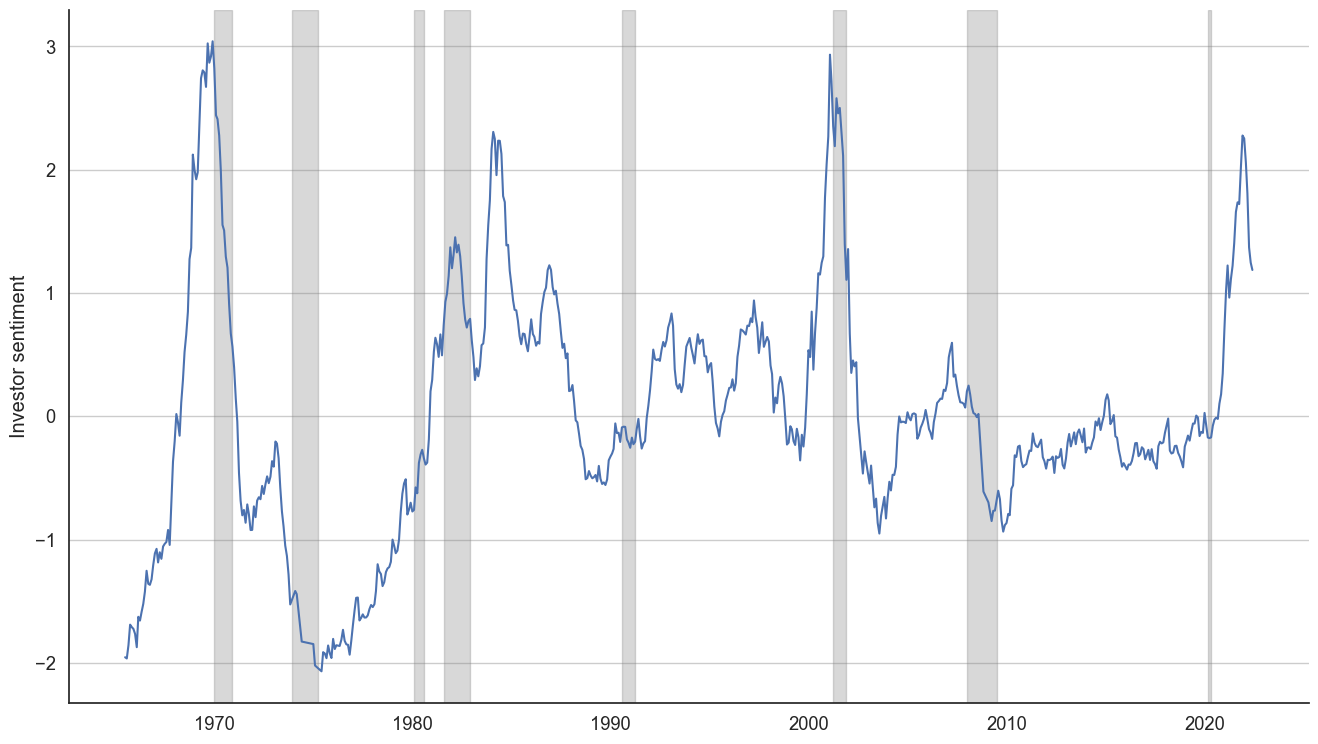

In [41]:
# plot investor sentiment data with NBER suggested recessions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

# load nber recession data
nber = pd.read_excel('raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

fig, ax = plt.subplots(1,1,figsize=(16,9))
sns.lineplot(data=sent, x='Date', y='SENT')
plt.xlabel('')
plt.ylabel('Investor sentiment')
ax.grid(axis='y')
# shade recession area
for i in range(8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

# remove frame
sns.despine(fig)

## Plot Sentiment Data

In [6]:
sent = pd.read_excel('raw_data/Investor_Sentiment_Data_20220821_POST.xlsx', sheet_name='DATA')
sent['year_month'] = pd.to_datetime(sent['yearmo'], format='%Y%m')
sent = sent[sent['year_month']>"1965-12-01"]
sent = sent[['year_month', 'SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's']]
sent = sent.fillna(sent.median(numeric_only=True))

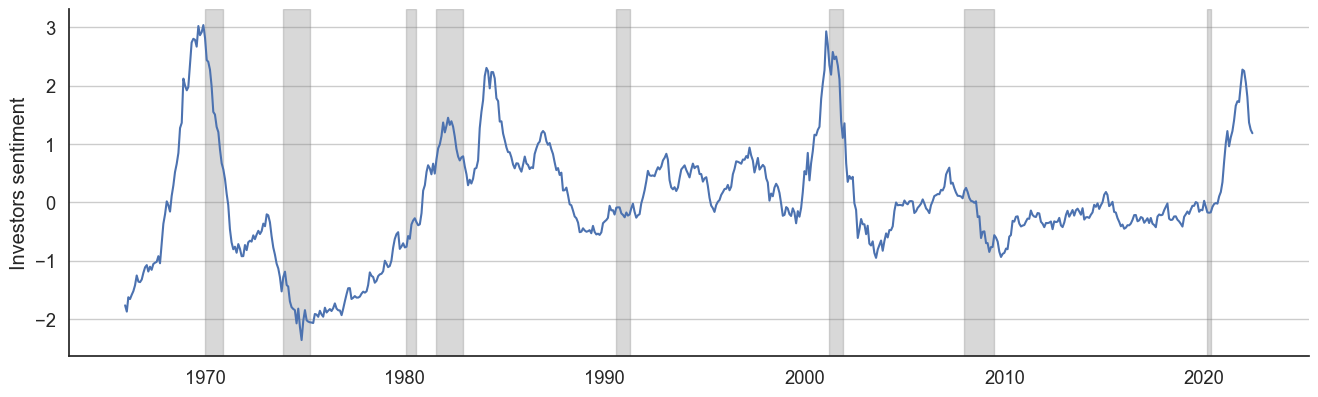

In [28]:
# plot CFNAI index with NBER suggested recessions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

# load nber recession data
nber = pd.read_excel('raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

fig, ax = plt.subplots(1,1,figsize=(16,4.5))
sns.lineplot(data=sent, x='year_month', y='SENT')
plt.xlabel('')
plt.ylabel('Investors sentiment')
ax.grid(axis='y')
# shade recession area
for i in range(8):
 ax.axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.3, color='grey')

# remove frame
sns.despine(fig)

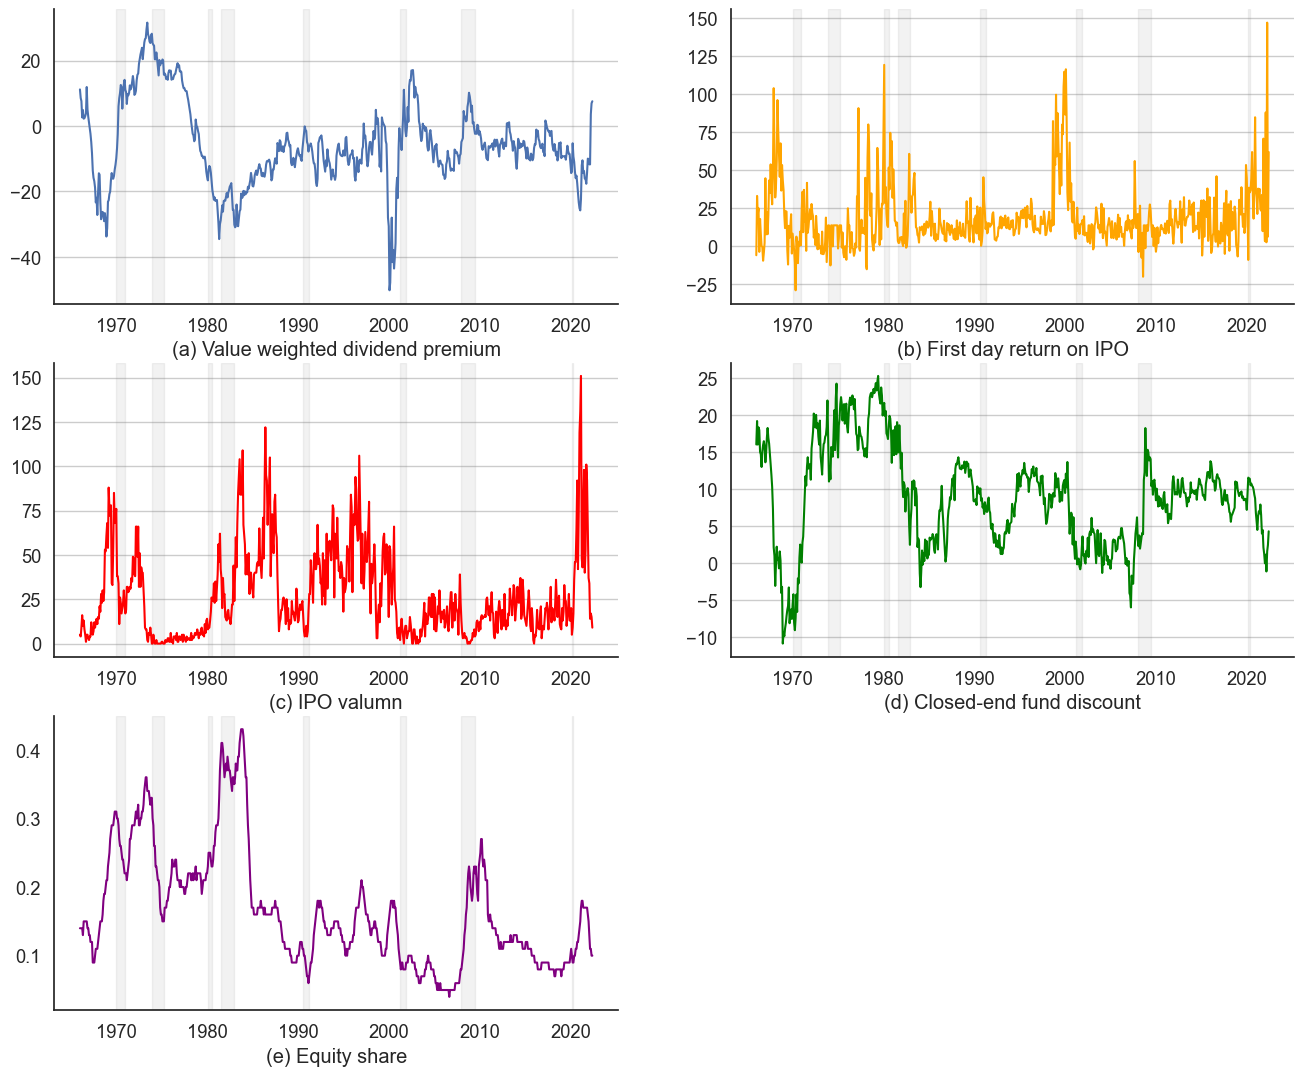

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.2, style='white')

fig, ax = plt.subplots(3,2, figsize=(16,13))
sns.lineplot(data=sent, x='year_month', y='pdnd', ax=ax[0][0])
sns.lineplot(data=sent, x='year_month', y='ripo', ax=ax[0][1], color='orange')
sns.lineplot(data=sent, x='year_month', y='nipo', ax=ax[1][0], color='red')
sns.lineplot(data=sent, x='year_month', y='cefd', ax=ax[1][1], color='green')
sns.lineplot(data=sent, x='year_month', y='s', ax=ax[2][0], color='purple')
ax[2][1].axis("off")

ax[0][0].set(xlabel='(a) Value weighted dividend premium', ylabel=None)
ax[0][1].set(xlabel='(b) First day return on IPO', ylabel=None)
ax[1][0].set(xlabel='(c) IPO valumn', ylabel=None)
ax[1][1].set(xlabel='(d) Closed-end fund discount', ylabel=None)
ax[2][0].set(xlabel='(e) Equity share', ylabel=None)

# shade recession area
for i in range(8):
 ax[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 ax[2][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')

 
for a in range(0,2):
  for b in range(0,2):
    ax[a][b].grid(axis='y')

# remove frame
sns.despine(fig)